# CNN con Pytorch

Repetimos el ejemplo de Keras pero ahora utilizando Pytorch. Como veremos es mucho mas complejo ya que nos permite definir mas en detalle todo el proceso.

In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Definimos la arquitectura de la CNN

Definimos como el modelo debe cargar los datos

In [2]:
class CustomMNISTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.encodings[idx])
        label = F.one_hot(torch.tensor(self.labels[idx]), num_classes=10).float()
        return image, label

Definimos el proceso de entrenamiento paso a paso

In [3]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

Definimos el proceso de validacion paso a paso

In [4]:
def validation(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target).sum().item()

    val_loss /= len(val_loader.dataset)
    print(f'\nTest set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

Cargamos los datos igual que hicimos antes

In [5]:
import requests, zipfile, io
r = requests.get("https://github.com/amiune/freecodingtour/raw/main/cursos/espanol/deeplearning/data/mnist/mnist_train.csv.zip")
with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zip_ref:
    zip_ref.extractall("./data/mnist/extracted/")
r = requests.get("https://github.com/amiune/freecodingtour/raw/main/cursos/espanol/deeplearning/data/mnist/mnist_test.csv.zip")
with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zip_ref:
    zip_ref.extractall("./data/mnist/extracted/")

In [6]:
train_df = pd.read_csv("./data/mnist/extracted/mnist_train.csv")

x_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values

# Hacer que cada pixel este entre 0 y 1
#x_train = x_train.astype("float32") / 255
x_train = x_train.astype(np.uint8)


# Cambiar la forma de unidimensional de (784) a bidimensional (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

El input tensor en Keras tiene que tener la forma  **(batch_size, height, width, channels)**

El input tensor en PyTorch tiene que tener la forma **(batch_size, channels, height, width)**

In [7]:
x_train.shape

(60000, 28, 28, 1)

In [8]:
from PIL import Image
  
# Convertir las imagenes de 1 capa (escala de grises) a 3 capas (RGB)
new_x_train = []
for i in range(len(x_train)):
    PIL_image = Image.fromarray(x_train[i][:,:,0])
    PIL_image = PIL_image.convert('RGB')
    PIL_image_resized = PIL_image.resize((32,32), Image.Resampling.LANCZOS)
    new_x = np.array(PIL_image_resized)
    new_x = new_x.astype("float32") / 255
    new_x_train.append(new_x)

In [9]:
x_train = np.array(new_x_train)

In [10]:
x_train.shape

(60000, 32, 32, 3)

In [11]:
x_train.transpose((0, 3, 1, 2)).shape

(60000, 3, 32, 32)

In [12]:
x_train = x_train.transpose((0, 3, 1, 2))

In [13]:
y_train

array([5, 0, 4, ..., 5, 6, 8])

Separamos manualmente los conjuntos de entrenamiento y validacion.
Antes lo hacia automaticamente keras

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [15]:
train_dataset = CustomMNISTDataset(x_train, y_train)
val_dataset = CustomMNISTDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [16]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [17]:
train_dataset[0][1].shape

torch.Size([10])

In [18]:
train_dataset[0][1]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [19]:
train_dataset[0][0].permute(1, 2, 0).shape

torch.Size([32, 32, 3])

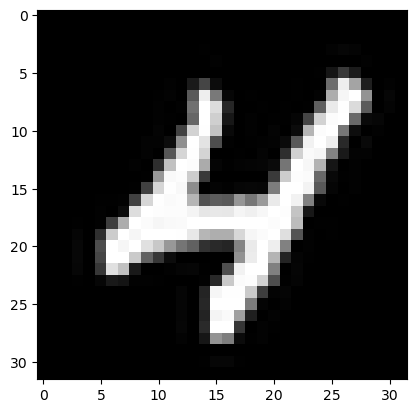

In [20]:
from matplotlib import pyplot as plt
plt.imshow(train_dataset[0][0].permute(1, 2, 0), interpolation='nearest')
plt.show()

In [33]:
import torchvision.models as models
model = models.mobilenet_v2(pretrained=True)

# Obtenemos los parametros y hacemos que no sean actualizables por el gradiente
for param in model.parameters():
    param.requires_grad = False
    
for param in model.features[15].parameters():
    param.requires_grad = True

model.classifier[1] = nn.Linear(model.last_channel, 10)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(1, 4):
    train(model, device, train_loader, criterion, optimizer, epoch)
    validation(model, device, val_loader, criterion)

#torch.save(model.state_dict(), "mnist_cnn.pt")

/Users/hernanamiune/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hernanamiune/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/51000 (0%)]	Loss: 2.582388
Train Epoch: 1 [6400/51000 (13%)]	Loss: 0.408376
Train Epoch: 1 [12800/51000 (25%)]	Loss: 0.411624
Train Epoch: 1 [19200/51000 (38%)]	Loss: 0.444288
Train Epoch: 1 [25600/51000 (50%)]	Loss: 0.447349
Train Epoch: 1 [32000/51000 (63%)]	Loss: 0.494381
Train Epoch: 1 [38400/51000 (75%)]	Loss: 0.319831
Train Epoch: 1 [44800/51000 (88%)]	Loss: 0.443428

Test set: Average loss: 0.0051, Accuracy: 8068/9000 (90%)

Train Epoch: 2 [0/51000 (0%)]	Loss: 0.377638
Train Epoch: 2 [6400/51000 (13%)]	Loss: 0.255722
Train Epoch: 2 [12800/51000 (25%)]	Loss: 0.218561
Train Epoch: 2 [19200/51000 (38%)]	Loss: 0.222641
Train Epoch: 2 [25600/51000 (50%)]	Loss: 0.204527
Train Epoch: 2 [32000/51000 (63%)]	Loss: 0.385991
Train Epoch: 2 [38400/51000 (75%)]	Loss: 0.235446
Train Epoch: 2 [44800/51000 (88%)]	Loss: 0.330158

Test set: Average loss: 0.0048, Accuracy: 8124/9000 (90%)

Train Epoch: 3 [0/51000 (0%)]	Loss: 0.331655
Train Epoch: 3 [6400/51000 (13%)]	Loss: 0.19352

In [34]:
test = pd.read_csv("./data/mnist/extracted/mnist_test.csv")

x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values

# Hacer que cada pixel este entre 0 y 1
#x_test = x_test.astype("float32") / 255
x_test = x_test.astype(np.uint8)
  
# Cambiar la forma de unidimensional de (784) a bidimensional (28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convertir las imagenes de 1 capa (escala de grises) a 3 capas (RGB)
new_x_test = []
for i in range(len(x_test)):
    PIL_image = Image.fromarray(x_test[i][:,:,0])
    PIL_image = PIL_image.convert('RGB')
    PIL_image_resized = PIL_image.resize((32,32), Image.Resampling.LANCZOS)
    new_x = np.array(PIL_image_resized)
    new_x = new_x.astype("float32") / 255
    new_x_test.append(new_x)
    
x_test = np.array(new_x_test)

#Cambiar al formato de pytorch
x_test = x_test.transpose((0, 3, 1, 2))

In [35]:
x_test[0:1,:].shape #(batch_size, layers, witdh, height)

(1, 3, 32, 32)

In [36]:
tensor = torch.tensor(x_test[0:1,:]).to(device)
tensor.shape

torch.Size([1, 3, 32, 32])

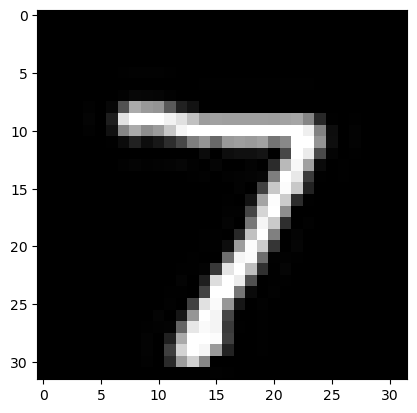

In [37]:
from matplotlib import pyplot as plt
plt.imshow(tensor[0].permute(1, 2, 0), interpolation='nearest')
plt.show()

In [38]:
model.eval()
with torch.no_grad():
    predictions = model(tensor)

In [39]:
predictions

tensor([[ -8.9352,  -4.6080,  -0.6466,  -3.8957,  -1.4508,  -5.8684, -14.7052,
           8.4866,  -5.4879,  -4.1535]])

In [40]:
predictions.argmax(axis=-1).flatten()

tensor([7])

# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/deeplearning/deeplearning.html)

## Referencias:

- https://github.com/pytorch/examples/blob/main/mnist/main.py
- https://www.kaggle.com/datasets/oddrationale/mnist-in-csv